In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
# dt = 0.004
# num_steps = 501
dt = 0.002
num_steps = 1001
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([1001, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

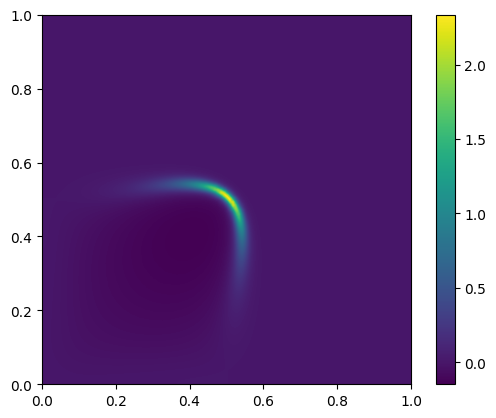

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = u_dot

In [8]:
m = 50
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

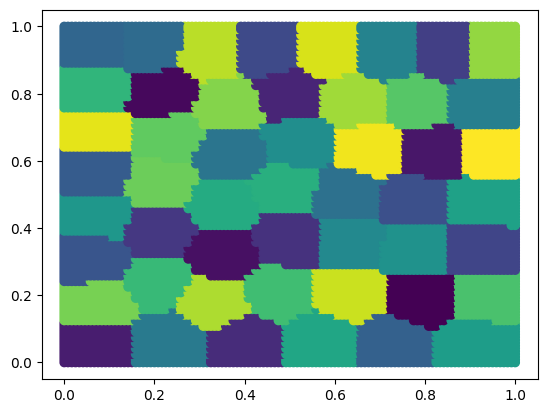

In [9]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

In [10]:
group_indices = []
for i in range(m):
    group_indices.append(torch.tensor(np.where(clustering.labels_ == i)[0], device=device))

In [11]:
N = datas.shape[1]
n = 30
mu = int(np.ceil(N/20))
neighbours = lib.utils.topk_neighbours(coords, mu)

In [12]:
batch_size = 20
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [13]:
ed = lib.nrbs_n_m.EncoderDecoder(N=N, n=n, mu=mu, m=m, neighbours=neighbours, group_indices=group_indices, device=device)

In [14]:
encoded = ed.nrbs.encode(datas[:15].to(device))

In [15]:
encoded.shape

torch.Size([15, 30])

In [16]:
decoded = ed.nrbs.decode(encoded)

In [17]:
decoded.shape

torch.Size([15, 14641])

In [18]:
ed.train(train_data_loader=train_data, epochs=100)

100%|██████████| 50/50 [02:54<00:00,  3.48s/it]


Itr 0, loss = 99147.31476057114


 46%|████▌     | 23/50 [01:19<01:35,  3.53s/it]

In [ ]:
ed.nrbs = torch.load('models/nrbs_n_m.pth')

In [ ]:
approximates = ed(datas[499:501].to(device))
approximates.shape

torch.Size([2, 14641])

In [ ]:
approximates[0]

tensor([ 0.0051,  0.0053,  0.0049,  ..., -0.0013, -0.0014, -0.0017],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
datas[499]

tensor([5.6850e-03, 5.3000e-03, 4.9000e-03,  ..., 2.6452e-47, 2.6452e-47,
        4.0860e-47])

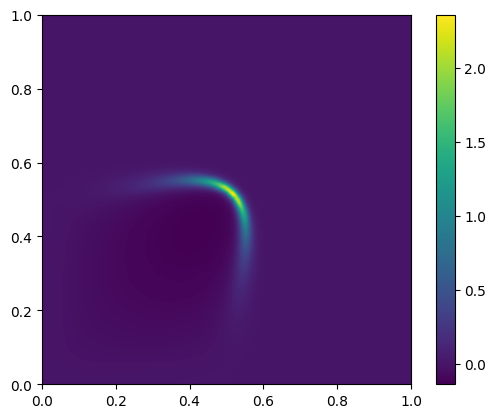

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[499].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

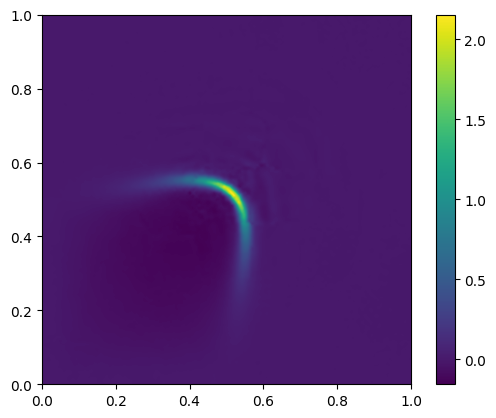

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

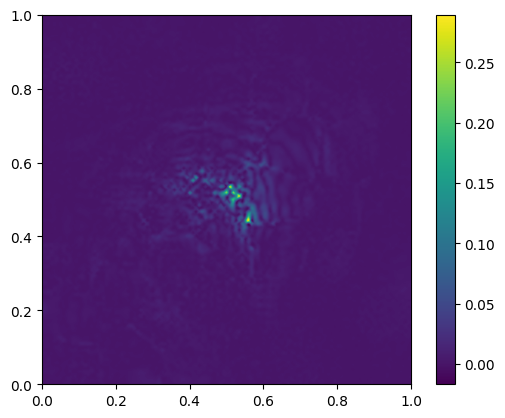

In [ ]:
err = abs(datas[499] - approximates[0].detach().cpu())

# data coordinates and values
z = err.tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
# bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
# bws = torch.sigmoid(bws)

In [ ]:
# bws = ed.nrbs.get_bandwidth(ed.nrbs.encode(datas[499:501].to(device)))

In [ ]:
# # data coordinates and values
# z = bws[0].detach().cpu().tolist()

# # target grid to interpolate to
# xi = yi = np.linspace(0,1.0,1200)
# xi,yi = np.meshgrid(xi,yi)

# # set mask
# # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# # interpolate
# zi = griddata((x,y),z,(xi,yi),method='cubic')

# plt.imshow(zi,origin='lower', extent=[0,1,0,1])
# plt.colorbar()